# “基于数据挖掘技术的优惠券核销率预测系统”项目报告
### 小组成员：刘卓睿、王聆煊、刘贤文、唐力
### 撰写人：刘卓睿

### 组员分工：
   #### 刘卓睿：报告撰写、代码完善与整合、GUI设计、模型部署与前后端交互
   #### 王聆煊：数据分析、数据可视化
   #### 刘贤文：模型调研、模型训练
   #### 唐力：GUI设计、前后端交互
### 项目代码仓库地址：https://github.com/ZhuoruiLiu12/DMproject.git

## 一、问题描述
### 1、问题背景及分析
随着移动设备的完善和普及以及互联网技术的发展，移动互联网+各行各业进入了高速发展阶段，这其中以O2O（Online to Offline）消费最为吸引眼球。以优惠券刺激消费者消费是O2O的一种重要营销方式，然而，随机投放的限定于某种类型的优惠券对于大多数用户来说，只会造成无意义的干扰；同样对于商家而言，滥发的优惠券可能降低品牌声誉，同时难以估算其营销成本。在此背景下，个性化投放是提高优惠券核销率的重要手段，它可以让具有一定偏好的消费者得到真正的实惠，同时赋予商家更强的营销能力，本项目使用O2O场景相关的数据，通过分析建模来预测用户是否会在规定时间内使用相应优惠券，从而帮助用户和商家解决上述问题，最终达到双赢的效果。
### 2、问题描述
#### 2.1 数据准备
该项目的数据集采用天池平台的数据集“生活大实惠：O2O优惠券使用预测”，根据用户一个月的线上线下真实消费记录，来预测用户在下一个月领取优惠券后15天内的使用情况。同时为了保护隐私，所有数据均作匿名处理，同时采用了有偏采样和必要过滤。
> datasets：https://tianchi.aliyun.com/dataset/137322
#### 2.2 准备采用的方法或者模型
本项目基于数据挖掘技术，机器学习与深度学习，数据可视化等技术，对数据进行预处理跟清洗，将处理后的数据使用特征工程进行建模，同时使用数据可视化技术将数据分析和关联挖掘的结果展现出来，使用机器学习或深度学习模型学习数据的特征，进行训练和预测。
在项目进行过程中，对不同的模型进行实验，得出对应的结果。分析之后，最终选择的模型为线性模型、随机森林模型、决策树模型，其中根据评估结果，随机森林模型效果最好。
#### 2.3 预期的挖掘结果
- 挖据并学习出数据对应的关联模式，并且对于测试集中的用户，能预测出其优惠券使用的概率
- 根据预测的概率结果，可以对个性化优惠券发放进行优化，从而实现更好的个性化推荐效果

## 二、数据处理与分析
### 1、导入数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
offline_train_data = pd.read_csv('datasets/offline_train.csv/offline_train.csv')

### 2、预处理数据
1. 首先是分析数据，发现对O2O消费券线下消费的预测，使用线上消费的数据并不能有一个很好的效果，所以我们选择使用户线下消费和优惠券领取行为表的一百七十多万条数据来进行项目的分析和预测。
2. 对于要使用的数据打上label，由于原始数据的属性如上表所示，并没有显示的给出数据的标签，所以我们根据项目的具体要求，结合数据说明中的属性，给符合要求的数据打上了0,1,-1的标签，方便后续的训练与预测。
> 给数据新增一条属性列，即label    
> 具体来说，对于数据的消费日期属性，如果Date=null & Coupon_id != null，该记录表示领取优惠券但没有使用，即负样本，给数据的label属性标记为0   
> 如果Date!=null & Coupon_id = null，则表示普通消费日期,给该数据的label属性标记为-1   
> 如果Date!=null & Coupon_id != null，则表示用优惠券消费日期，即正样本，给该数据的label属性标记为1
3. 由于没有领券的用户消费行为不作为本次项目的分析样本，所以将label为-1的数据从数据中删除。

定义预处理函数

In [4]:
def pre_process_data(df):
    """
    todo: 预处理数据,包括构建label、去除无用数据
    @return:
    """
    # *添加label
    df['label'] = df.apply(create_label4offline_train, axis=1)
    print(df['label'].value_counts())
    # *去除没有接收领优惠卷的用户,因为不是我们这次分析的样本，需要从样本空间删除
    df = df[df['label'] != -1]
    print(df['label'].value_counts())
    # *保存数据
    df.to_csv('processed_offline_train.csv', index=False)

In [6]:
def create_label4offline_train(row):
    """
    todo:为offline_train创建label 1-表示在15天内使用了优惠券，0-表示没有使用，-1-表明没有领优惠劵
    @param row:
    @return:
    """
    # if pd.isnull(row['Date']) and (not pd.isnull(row['Coupon_id'])):
    if pd.isnull(row['Date']):
        if not pd.isnull(row['Coupon_id']):
            # 如果Date=null & Coupon_id != null，该记录表示领取优惠券但没有使用，即负样本
            return 0
    else:
        # Date != null
        if pd.isnull(row['Coupon_id']):
            # Coupon_id = null，则表示普通消费日期
            return -1
        else:
            # 如果Date!=null & Coupon_id != null，则表示用优惠券消费日期，即正样本
            return 1

In [7]:
pre_process_data(offline_train_data)

label
 0    977900
-1    701602
 1     75382
Name: count, dtype: int64
label
0    977900
1     75382
Name: count, dtype: int64


读取处理后的数据

In [8]:
df_pro = pd.read_csv('datasets/offline_train.csv/processed_offline_train.csv')

### 3、分析数据
1. 对数据的缺失值和重复值分析  

|不重复数据|重复数据|
|------|------|
|1015389|37893|   

----

| 属性 | 空值统计 |
| ------|-------|
| User_id|0|
| Merchant_id|0|
|Coupon_id|0|
|Discount_rate|0|
|Distence|106003|
|Date_received|0|
|Date|977900|
|label|0|

表中Distence属性有106003条null值，表示没有记录商家距离  
Date属性为null表示未使用消费券    
数据分析结果表示，共有37893条重复数据，不重复的数据有1015389条；无缺失数据；无异常值   
2. 数据分布分析

定义相关函数


In [9]:
def user_count(data):
    """
    @todo 区分高活跃度用户-3，中度活跃用户-2以及低活跃度用户-1，以及流失用户-0
    @param data:
    @return:
    """
    if data > 10:
        return 3
    elif data > 5:
        return 2
    elif data > 1:
        return 1
    else:
        return 0

In [10]:
def user_id(df):
    """
    todo: 分析user id属性
    @return:
    """
    print("total number is %d" % len(df.User_id))
    print("unique user id is %d" % len(set(df.User_id)))
    df['sum'] = 1  # 给每一条记录付给一个初始值1,记录出现的次数
    user_id_count = df.groupby(['User_id'], as_index=False)['sum'].agg({'count': np.sum})  # 统计各个用户出现的次数
    user_id_count.sort_values('count', ascending=False, inplace=True)
    print(user_id_count.head(20))
    # 可视化
    user_id_count['user_range'] = user_id_count['count'].map(user_count)
    f, ax = plt.subplots(1, 2, figsize=(17.5, 8))
    user_id_count['user_range'].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax[0], explode=[0.01, 0, 0, 0],
                                                    startangle=90)
    ax[0].set_title('user_range_ratio')
    ax[0].set_ylabel('')
    # user_id_count['user_range'].value_counts().plot(kind='bar',ax=ax[1])
    sns.countplot(x='user_range', data=user_id_count, ax=ax[1])
    ax[1].set_title('user range distribution')
    plt.savefig("用户活跃度.png")
    plt.show()

In [11]:
def mer_count(data):
    if data > 1000:
        return 3
    elif data > 100:
        return 2
    elif data > 20:
        return 1
    else:
        return 0

In [12]:
def merchant_id(df):
    """
    todo: 分析merchant id属性
    @param df:
    @return:
    """
    print("total number is %d" % len(df.Merchant_id))
    print("unique user id is %d" % len(set(df.Merchant_id)))
    print("total number is %d" % len(df.Merchant_id))
    print("unique user id is %d" % len(set(df.Merchant_id)))
    df['sum_Merchant_id'] = 1  # 给每一条记录付给一个初始值1,记录出现的次数
    merchant_count = df.groupby(['Merchant_id'], as_index=False)['sum_Merchant_id'].agg(
        {'count': np.sum})  # 统计各个用户出现的次数
    merchant_count.sort_values('count', ascending=False, inplace=True)
    print(len(merchant_count))
    print(merchant_count.head(20))
    # visualization
    merchant_count['mer_range'] = merchant_count['count'].map(mer_count)  # 对商家也进行编码，3代表发放了很多的优惠券，2,1,0一次抵减
    f, ax = plt.subplots(1, 2, figsize=(17.5, 8))
    merchant_count['mer_range'].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax[0], explode=[0.01, 0, 0, 0],
                                                    startangle=90)
    ax[0].set_title('mer_range')
    ax[0].set_ylabel('')

    sns.countplot(x='mer_range', data=merchant_count, ax=ax[1])
    ax[1].set_title('merchant range distribution')
    plt.savefig("商家分布.png")
    plt.show()

In [13]:
def cou_count(data):
    if data > 1000:
        return 3
    elif data > 100:
        return 2
    elif data > 10:
        return 1
    else:
        return 0

In [14]:
def coupon_id(df):
    """
    @todo 分析coupon id属性
    @param df:
    @return:
    """
    # 观察有发放优惠券的商家行为
    cou_id_count = df.groupby(['Coupon_id'], as_index=False)['sum'].agg({'count': np.sum})
    cou_id_count.sort_values(["count"], ascending=False).head(10)
    # visualization
    cou_id_count['Cou_range'] = cou_id_count['count'].map(cou_count)
    # 绘图
    f, ax = plt.subplots(1, 2, figsize=(17.5, 8))
    cou_id_count['Cou_range'].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax[0], explode=[0.01, 0, 0, 0],
                                                  startangle=90)
    ax[0].set_title('Cou_range')
    ax[0].set_ylabel('')

    sns.countplot(x='Cou_range', data=cou_id_count, ax=ax[1])
    ax[1].set_title('Cou_range distribution')
    plt.savefig("优惠券分布.png")
    plt.show()

由于数据中的距离跟折扣率存在字符表示或有特殊意义，但算法仅能处理数值类型，因此要定义两个转换函数，将特殊表示和字符表示转化为算法能识别的数值表示。

In [15]:
def convertRate(row):
    """Convert discount to rate"""
    if pd.isnull(row):
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return np.round(1.0 - float(rows[1]) / float(rows[0]), 2)
    else:
        return float(row)

In [16]:
def convertDistance(row):
    """Convert Distance to rate"""
    if pd.isnull(row):
        row = -1
    return int(row)

In [17]:
def date(df):
    """
    @todo 分析Date_received和Date属性
    @param df:
    @return:
    """
    # couponbydate = df[['Date_received', 'Date']].groupby(['Date_received'],as_index=False).count()
    couponbydate = df[df['Date_received'] != 'null'][['Date_received', 'Date']].groupby(
        ['Date_received'],
        as_index=False).count()
    couponbydate.columns = ['Date_received', 'count']
    # df_temp = df[~df['Date'].isna()]
    # buybydate = df_temp[['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
    buybydate = \
        df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][
            ['Date_received', 'Date']].groupby(
            ['Date_received'], as_index=False).count()
    buybydate.columns = ['Date_received', 'count']
    date_buy = df['Date'].unique()  # 购物的日期
    date_buy = sorted(date_buy[~np.isnan(date_buy)])  # 按照购物的日期进行排，排出null值

    date_received = df['Date_received'].unique()  # 接收到优惠券的时间
    date_received = sorted(date_received[~np.isnan(date_received)])  # 按照接收优惠券的时间排序

    sns.set_style('ticks')
    sns.set_context("notebook", font_scale=1.4)
    plt.figure(figsize=(12, 8))
    date_received = [int(x) for x in date_received]
    date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')  # 转换为datetime格式
    plt.subplot(211)
    plt.bar(date_received_dt, couponbydate['count'], label='number of coupon received',
            color='#a675a1')  # 绘制接收优惠券的日期对应的bar图
    plt.bar(date_received_dt, buybydate['count'], label='number of coupon used', color='#75a1a6')  # 绘制使用优惠券对应的bar图
    plt.yscale('log')
    plt.ylabel('Count')
    plt.legend()
    plt.savefig("优惠券使用图.png")
    plt.show()

    plt.subplot(212)
    plt.bar(date_received_dt, buybydate['count'] / couponbydate['count'], color='#62a5de')  # 绘制优惠券使用的比例图
    plt.ylabel('Ratio(coupon used/coupon received)')
    plt.tight_layout()
    plt.savefig("优惠券使用比例图.png")
    plt.show()

定义分析属性之间相关关系函数。

In [18]:
def attr_corr(df):
    """
    @todo 分析属性之间相关关系并作图
    @param df:
    @return:
    """
    df_corr = df.corr()
    print(df_corr)
    plt.subplots(figsize=(12, 9))
    sns.heatmap(df_corr, square=True, vmax=1, vmin=-1, center=0)
    plt.savefig("属性相关性heatmap.png")
    plt.show()

定义分析数据函数。

In [40]:
def analysis_data(df):
    """
    todo: 分析数据质量、分布
    """
    # *分析重复数据
#     print(df_pro.duplicated().value_counts())
    # *分析缺失值
#     print(df_pro.isnull().sum())
    # *分析User_id
#     user_id(df)
    # *分析商家
#     merchant_id(df)
    # *分析优惠券
#     coupon_id(df)
    # *分析优惠力度
#     df['Discount_rate'] = df['Discount_rate'].astype(str).apply(convertRate)
#     (df['Discount_rate'].value_counts() / len(df)).plot(kind='bar', title="discount_rate")
    # plt.savefig("优惠力度统计.png")
#     plt.show()
    # *分析距离
#     df['Distance'] = df['Distance'].apply(convertDistance)
#     df['Distance'].unique()
#     (df['Distance'].value_counts() / len(df)).plot(kind='bar',title='distance from merchant')
    # plt.savefig("商家距离统计.png")
#     plt.show()
    # *分析Date_received和Date属性
#     date(df)
    # *分析属性之间相关关系
    attr_corr(df)

### User_id分析


total number is 1053282
unique user id is 510698
        User_id  count
460801  6641735    120
190299  2751537    119
350192  5054119     96
480797  6929894     95
196443  2839484     83
340700  4917111     80
34591    501441     73
111133  1605133     70
174405  2520933     69
85746   1243042     69
335436  4840568     59
173492  2507268     57
341671  4931155     56
461774  6655171     52
372659  5378522     49
289206  4178170     48
203525  2940145     47
151456  2190887     46
146384  2117872     46
484011  6977597     44


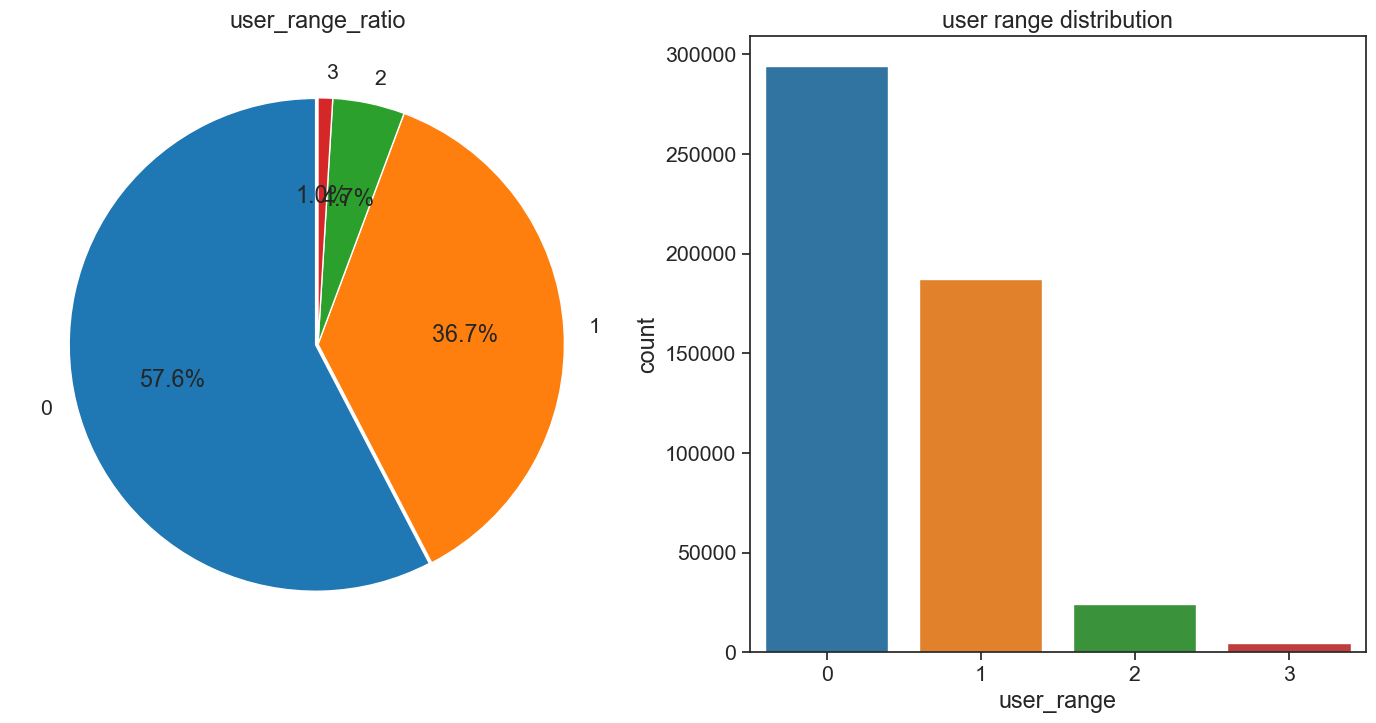

In [25]:
analysis_data(df_pro)

首先是一个用户编号，在工程里用户特征是非常重要的，因为它具有个性化及统计意义。这个工程属于用户画像的一部分，比如用户的年龄划分，性别划分，教育程度划分都是基础的工作，当然在这个工程里并没有年龄，性别及教育程度的特征，可以不作讨论。  
区分高活跃度用户-3，中毒活跃用户-2以及低活跃度用户-1，以及流失用户-0，做出图形化表示
这个属性总数是1053282，但唯一标识的用户有510698，说明有用户重复领取一家店铺的优惠券，这也就解释了我们在质量分析中有大量的重复数据，这种情况下不属于异常情况，在后续分析中需要留意。
我们识别出重复出现次数最多的20条用户的ID，这些用户是比较喜欢领取购物卷的客户，属于高活跃度用户。  
> 从这个可视化结果，我们可以得到活跃度为1的用户占训练集的36.7%，活跃度为2的用户占4.7%，活跃度为3的用户占1%，其中消费记录在10次以上的活跃度定义为3,消费记录为5-9次的活跃度定义为2，消费记录为1-4的活跃度定义为1，只有一次记录的活跃度定义为0。

### Merchant_id分析

total number is 1053282
unique user id is 5599
total number is 1053282
unique user id is 5599
5599
      Merchant_id   count
2135         3381  122834
281           450   63042
482           760   44976
3368         5341   36162
1707         2709   35330
986          1569   33600
4785         7555   27713
2936         4660   24867
4049         6454   21575
2279         3621   20779
905          1433   20467
1322         2099   16824
4036         6434   16529
2938         4663   15191
927          1469   14531
3062         4860   14102
4446         7019   14004
4364         6901   13886
4070         6485   13439
3596         5717   12875


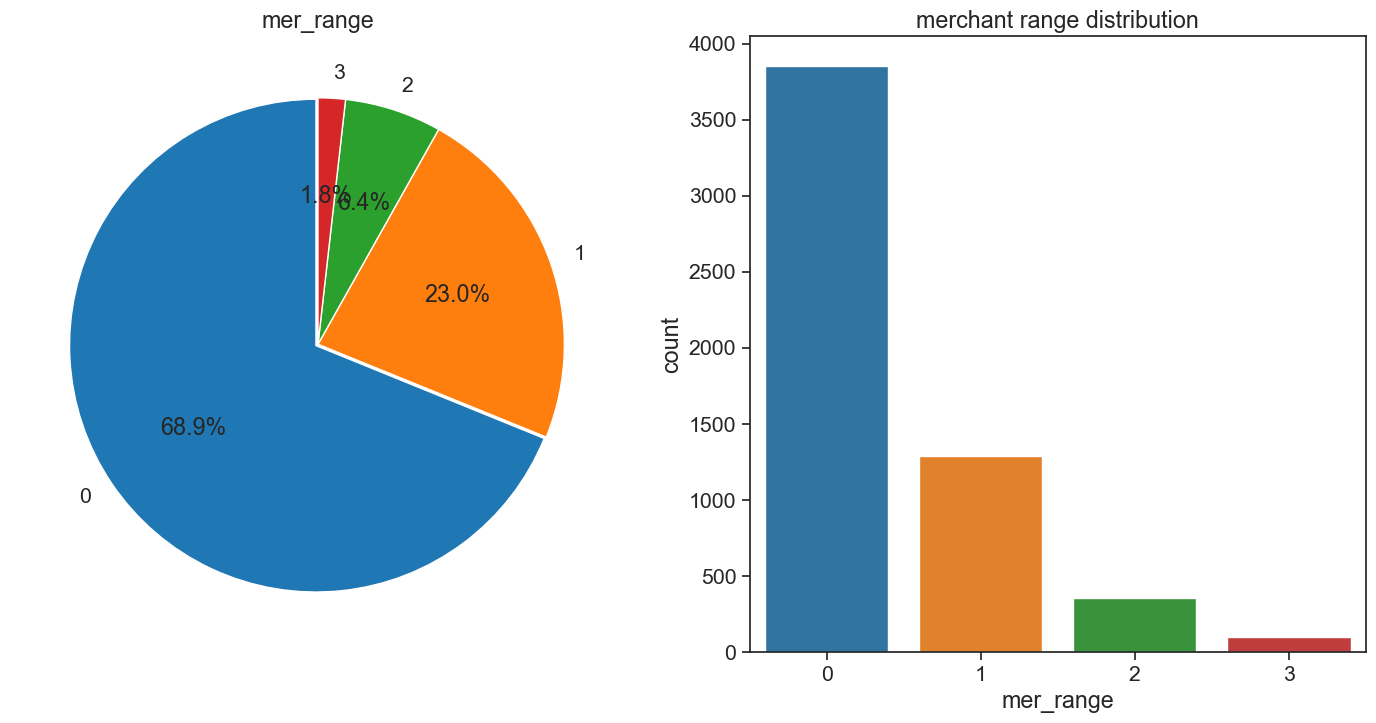

In [27]:
analysis_data(df_pro)

同上，定义商家活跃度，店铺记录大于1000的活跃度定义为3，店铺记录在100-1000之间的活跃度定义为2，店铺记录在20-100之间的活跃度定义为1，不足20的活跃度定义为0。  
> merchant代表的商家，根据商家记录出现的次数划分商家，记录的数据小于等于20的占训练集的68.9%，大于20小于等于100次数占23.0%，大于100小于等于1000占6.4%，超过1000次记录占1.8%。统计次数最多的商家编号是3381，超过14万。

### Coupon_id分析

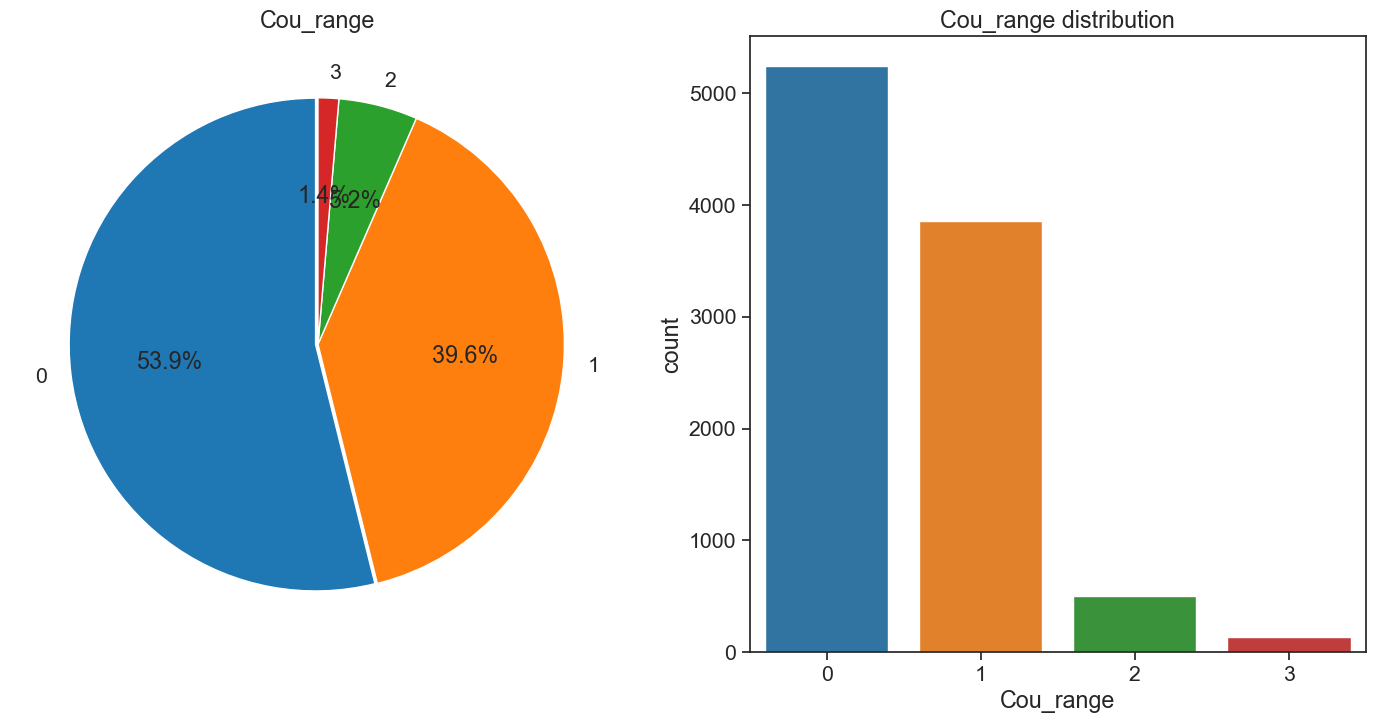

In [29]:
analysis_data(df_pro)

观察有发放优惠券的商家行为，发放数量大于1000的，将该id的活跃度定义为3，100-1000之间的活跃度定义为2，10-100之间的活跃度定义为1，不足10的活跃度定义为0。  
> 在有优惠券的数据里，活跃度0的占53.9%，活跃度1的占39.6%，活跃度2的占5.2%，活跃度3的占1.4%，统计次数最多的优惠券编号是7610，超过4.6万。

### Discount_rate分析

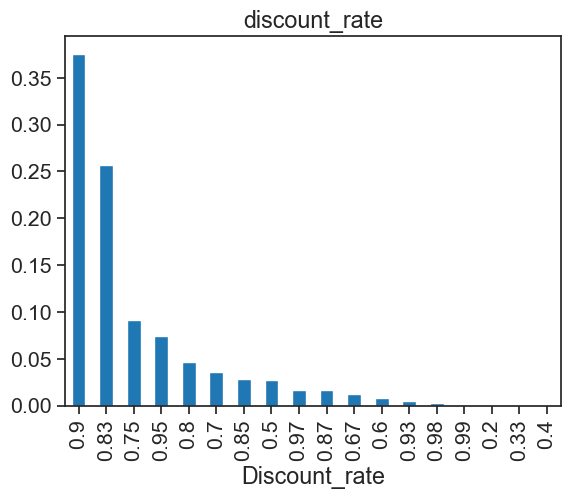

In [37]:
analysis_data(df_pro)

由于数据类型问题，可视化之前需要进行数据转换：x \in [0,1]代表折扣率；x:y表示满x减y。单位是元 查看对应的数据格式中，1为NULL，2为(:),3为小数 像这种数据其实需要一定的数据转化，按照经验可以用(1-(20/150))为折扣率。  
> 打折的优惠券的折扣率基本分布在0.5至0.97之间，9折优惠券最多，8.3折其次。

### Distance分析

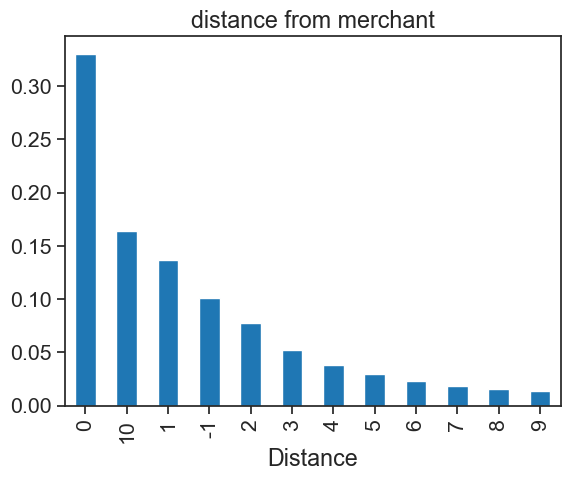

In [39]:
analysis_data(df_pro)

经常活动的地点离该merchant的最近门店距离是x*500米（如果是连锁店，则取最近的一家门店），x\in[0,10]；null表示无此信息，0表示低于500米，10表示大于5公里；对于null值进行编码，将null值编码为-1，进行数据可视化。
> 可以统计Distance为0占总数的30%以上，在图中可以看到数据缺失值大概占11%左右，5公里以内距离越大占比越低，5公里之外的占比约为16%左右，可能是去该远处的商店特意去买某类商品

### Date_received和Date分析

![](images/%E4%BC%98%E6%83%A0%E5%88%B8%E4%BD%BF%E7%94%A8%E5%9B%BE.png)

![](images/%E4%BC%98%E6%83%A0%E5%88%B8%E4%BD%BF%E7%94%A8%E6%AF%94%E4%BE%8B%E5%9B%BE.png)

上图为消费券发放与使用的柱状图，下图为消费券使用的比例图。
> 从上图可以看出在2016年2月份左右，对应的时间为春节，优惠券发放数目是最多（上图），但消费的比例是最低的（下图），因此可以得出春节是一个比较明显的特征，而5月1日的表现却属于中规中矩，因此对于节日特征的选择需要慎重。   
> 其次在3月20日左右，消费的比列是最高的，这种现象其实需要深究，比如说3月20日左右是否优惠券的折扣力度是否提高，那么就要观察折扣率力度大的优惠券折扣率在3月20日左右分布如何，是否比平时折扣率的力度要大等等。这些会在复合字段去分析，其实包活上述优惠券每天领取，消费，消费的比例都属于复合特征的一部分。

### 属性相关性分析

                  User_id  Merchant_id  Coupon_id  Discount_rate  Distance   
User_id          1.000000     0.002253   0.000356       0.001642 -0.000065  \
Merchant_id      0.002253     1.000000   0.022176       0.115809  0.012783   
Coupon_id        0.000356     0.022176   1.000000      -0.020009  0.053317   
Discount_rate    0.001642     0.115809  -0.020009       1.000000 -0.004334   
Distance        -0.000065     0.012783   0.053317      -0.004334  1.000000   
Date_received   -0.001886    -0.112708  -0.103350      -0.074005 -0.249921   
Date             0.000423    -0.011479  -0.101008       0.096326  0.056721   
label            0.001979     0.028828   0.013425      -0.032779 -0.145253   
sum                   NaN          NaN        NaN            NaN       NaN   
sum_Merchant_id       NaN          NaN        NaN            NaN       NaN   

                 Date_received      Date     label  sum  sum_Merchant_id  
User_id              -0.001886  0.000423  0.001979  NaN           

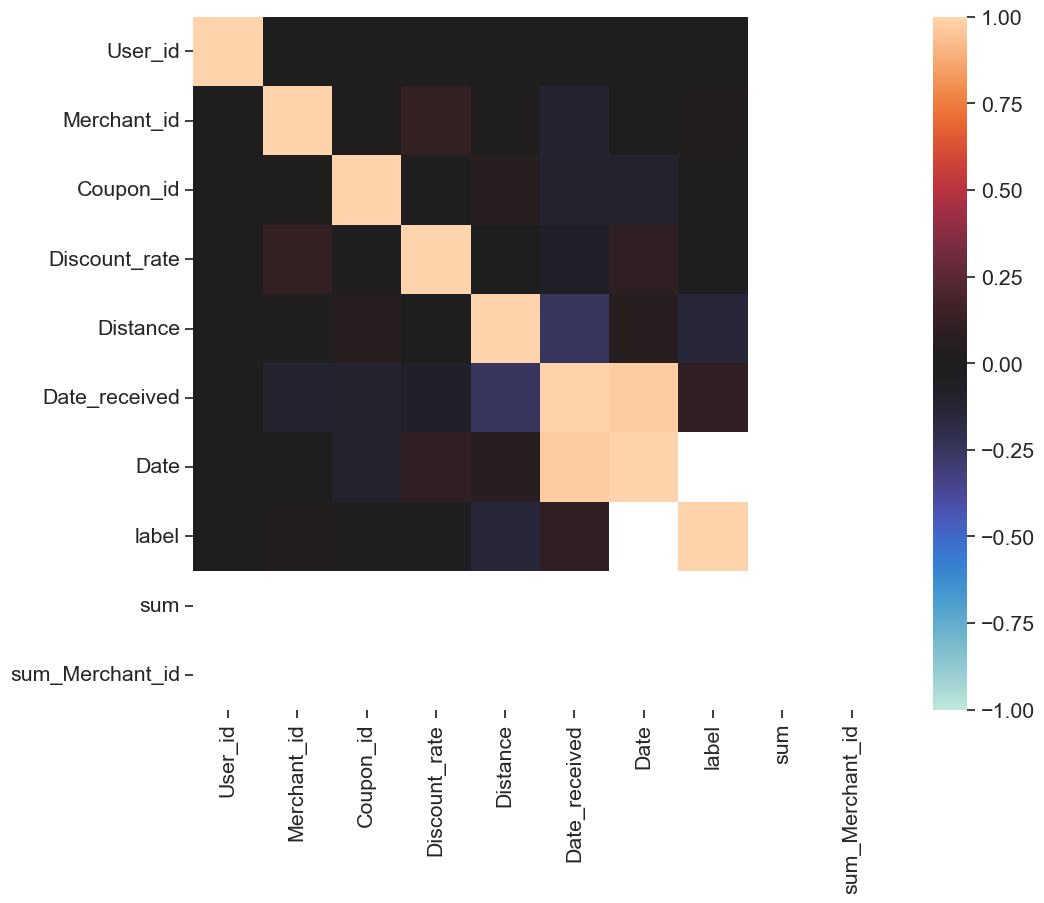

In [41]:
analysis_data(df_pro)

相关性分析只针对数值类型，所以需要把特征转换为数值类型。  
使用皮尔逊相关系数计算各个数值属性对应的相关关系，以及属性与label的相关关系，并使用图表的形式显示。  
> 可以看到属性之间的相关关系，Date和Date_received之间相关性强，Distance和Date_received之间负相关，这从直觉上也可以理解。Date属性的heatmap为空值的原因是存在未使用优惠券的样本，即负样本，Date为空值，故对应heatmap为空。

### 组合特征分析

####  UM(User_id and Merchant_id)组合特征

In [45]:
um_count = df_pro.groupby(['User_id','Merchant_id'], as_index = False)['sum'].count()
um_count.head(5)

,User_id,Merchant_id,sum
0,4,1433,1
1,4,1469,1
2,35,3381,4
3,36,1041,1
4,36,5717,1


In [46]:
um_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856475 entries, 0 to 856474
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   User_id      856475 non-null  int64
 1   Merchant_id  856475 non-null  int64
 2   sum          856475 non-null  int64
dtypes: int64(3)
memory usage: 19.6 MB


这个特征就可以告诉我们，每个用户所对应的商家的记录有多少条

####  UC(User_id and Coupon_id)组合特征

In [43]:
uc_count = df_pro.groupby(['User_id','Coupon_id'], as_index = False)['sum'].agg({'count':np.sum})
uc_count.head(10)

,User_id,Coupon_id,count
0,4,2902.0,1
1,4,8735.0,1
2,35,1807.0,1
3,35,9776.0,1
4,35,11951.0,2
5,36,12349.0,1
6,36,13490.0,1
7,64,11173.0,1
8,110,190.0,1
9,110,3887.0,1


In [48]:
uc_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957758 entries, 0 to 957757
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   User_id    957758 non-null  int64  
 1   Coupon_id  957758 non-null  float64
 2   count      957758 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 21.9 MB


同样可以统计得到每个用户所对应优惠券的数目，再根据上述UM统计可以知道编号为4，35分别有2次及3次记录，而这些记录都是有优惠券。

#### UR(User_id and Discount_rate)组合特征

In [50]:
ur_count = df_pro.groupby(['User_id','Discount_rate'], as_index = False)['sum'].agg({'count':np.sum})
ur_count.head()

,User_id,Discount_rate,count
0,4,0.83,1
1,4,0.95,1
2,35,0.50,1
3,35,0.90,3
4,36,0.75,1


In [51]:
ur_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751337 entries, 0 to 751336
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   User_id        751337 non-null  int64  
 1   Discount_rate  751337 non-null  float64
 2   count          751337 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 17.2 MB


可以统计用户优惠券折扣率的分布情况，也可以统计到每个用户平均折扣率。

####  UD(User_id and Distance)组合特征

In [53]:
ud_count = df_pro.groupby(['User_id','Distance'], as_index = False)['sum'].agg({'count':np.sum})
ud_count.head()

,User_id,Distance,count
0,4,10,2
1,35,0,4
2,36,4,1
3,36,8,1
4,64,2,1


In [54]:
ud_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700569 entries, 0 to 700568
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   User_id   700569 non-null  int64
 1   Distance  700569 non-null  int64
 2   count     700569 non-null  int64
dtypes: int64(3)
memory usage: 16.0 MB


客户4在距离10即超过5公里的地方领取了2单优惠券

## 三、模型选择
### 1、模型调研

备选模型
- LR：LR回归使用sigmoid函数，将线性模型 wTx 的结果压缩到[0,1] 之间，使其拥有概率意义。其本质还是一个线性模型，实现相对简单。    
   优点：   
       1. 计算代价不高，对时间和内存需求较小,很适合大数据
       2. 使用梯度下降的优化算法可以用于分布式系统，并且还有在线算法实现，用较少的资源处理大型数据
       3. LR对于数据中小噪声的鲁棒性很好，并且不会受到轻微的多重共线性的特别影响 
      
   缺点：  
       1. 不适应数据缺失，特征空间很大的数据
- SVM：假设问题是二分类器，就是在特征空间中寻找使正类负类间隔最大的超平面的线性分类器。根据输入的数量类型不同，得到分类器也不同。    
   优点：   
       1. SVM有多种核可以选择，可以处理各种非线性问题
       2. SVM 的最终决策函数只由少数的支持向量所确定,计算的复杂性取决于支持向量的数目,而不是样本空间的维数,这在某种意义上避免了“维数灾难”
       3. 支持向量样本集具有一定的鲁棒性 
   
   缺点：  
       1. SVM算法对大规模训练样本难以实施.因为SVM用二次规划求解支持向量，数目很大，时间消耗很大,大多数情况准确率都比LR要高，但是模型较大，训练效率低。
       2. 用SVM解决多分类问题存在困难,经典的算法只给出了二分类的情况
- RF：针对样本，会随机抽取不同的样本和特征训练不剪枝的CART树，一直训练到达到预定义的基分类器个数。对于输出，针对分类问题，预测结果是各个基分类器的投票，针对回归问题，预测结果是各个分类器的输出结果的平均值。   
   优点：   
       1. 相比GBST,它默认参数的效果不错,可以很好地作为baseline模型
       2. 时间复杂度主要取决于数据集的复杂程度,如果数据集很复杂的话, 需要100-200棵树, 如果不复杂的话,一般10-100棵树就好
       3. 模型很简单 
       4. 采取随机采取的方式,不一定会采到特征, 所以抗噪声能力很好
   
   缺点：  
       1. 空间复杂度因为需要训练大量的树, 所以很耗内存
       2. 每个基分类器的准确率不是很高，所以要求有大量的基分类器才能取得良好的效果，一般是100-200，整体的训练时间很长

- ADABoost：将样本初始赋一个权重，用这些样本训练一个基分类器，根据这个基分类器对样本的表现调整样本的权重，如果样本分类器正确的话，权重降低，如果样本分类错误的话，权重上升。再用调整过的权重的样本训练基分类器，反复学习知道分类器个数达到指定个数。对预测样本的输出是结合所有基分类器的权重输出。最小化目标是指数损失函数。      
   优点：   
       1. 在小数据上, 模型选用简单的树模型, 有深度限制并且不需要大量的树, 所以时间很快
       2. 需要树的数量少, 消耗的空间也就小
       3. 树的个数和缩减率,调参是比较容易的
       4. 不改变训练数据，只是改变训练样本的权重分布

   缺点：  
       1. 模型稍微优点复杂,主要是样本的权重调整计算公式上
       2. 过分关注容易错误分类的样本，如果错误分类样本是噪声点，那么算法容易产生过拟合
       3. 是个二分类算法

- GBDT：是一种迭代的决策回归树算法,也是一种典型的Boosting算法。      
   优点：   
       1. 准确率: 针对分类和回归任务都有很好的性能
       2. 时间: 小型的数据上,不需要训练大量的树, 模型也比较简单, 时间复杂度较小
       3. 空间较小
       4. 模型最后的公式很简单

   缺点：  
       1. 在大数据上, 不能用类似 mini batch 的方式来训练，需要对数据进行无数次的遍历。如果想要速度，就需要把数据都预加载在内存中，但这样数据就会受限于内存的大小；如果想要训练更多的数据，就要使用外存版本的决策树算法。虽然外存算法也有较多优化，SSD也在普及，但在频繁的 IO 下，速度还是比较慢的。
       2. 对噪声异常敏感
       
       
- 选择理由：首先SVM和LR淘汰：SVM解决小样本情况下的机器学习问题上有很大优势，而这是一个大样本问题。LR处理非线性特征效果不好。

最终选择RF和DT两个模型

### 2、模型训练
#### 数据准备

In [56]:
import pandas as pd
import numpy as np


#show the result with picture
import seaborn as sns
from matplotlib import pyplot as plt
#show the datetime info
from datetime import datetime
from  sklearn  import  preprocessing

from sklearn.model_selection import train_test_split

In [57]:
train = pd.read_csv('datasets/offline_train.csv/processed_offline_train.csv')
select_columns=['User_id', 'Merchant_id', 'Coupon_id',  'Distance',
       'Date_received', 'Discount_rate']
X_data = train[select_columns]
X_data['Discount_rate'] = X_data['Discount_rate'].apply(convertRate)
X_data['Distance'] = X_data['Distance'].apply(convertDistance)
y_label = train['label']
print("X_data is ",np.shape(X_data))
print(X_data)
print(y_label.value_counts())

C:\Users\24582\AppData\Local\Temp\ipykernel_2284\1959929184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data['Discount_rate'] = X_data['Discount_rate'].apply(convertRate)


X_data is  (1053282, 6)
         User_id  Merchant_id  Coupon_id  Distance  Date_received   
0        1439408         4663    11002.0         1     20160528.0  \
1        1439408         2632     8591.0         0     20160217.0   
2        1439408         2632     1078.0         0     20160319.0   
3        1439408         2632     8591.0         0     20160613.0   
4        1439408         2632     8591.0         0     20160516.0   
...          ...          ...        ...       ...            ...   
1053277   212662         3021     3739.0         6     20160504.0   
1053278   212662         2934     5686.0         2     20160321.0   
1053279   212662         3021     3739.0         6     20160508.0   
1053280   752472         7113     1633.0         6     20160613.0   
1053281   752472         3621     2705.0         0     20160523.0   

         Discount_rate  
0                 0.87  
1                 0.95  
2                 0.95  
3                 0.95  
4                 0.95

C:\Users\24582\AppData\Local\Temp\ipykernel_2284\1959929184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data['Distance'] = X_data['Distance'].apply(convertDistance)


筛选特征，本数据是由于特征个数比较少，所以从业务的角度分析获取那些特征：由于Date存在null值，而且这个值不是缺失值，代表具体的含义即没用没有使用，而用户用不用优惠卷，使用label来表示，所以把Date（消费优惠券的时间）这个属性删除。最后初步筛选的特征为'User_id', 'Merchant_id', 'Coupon_id', 'Distance', 'Date_received','Discount_rate'。

由于目标label变量存在分布不均匀的问题，在模型训练的时候需要对样本进行重采样（SMOTE），然后对数据进行标准化（归一化）

In [58]:
from sklearn.preprocessing import MinMaxScaler#导入包
min_max_scaler = MinMaxScaler()#创建模型
X_data_normal = pd.DataFrame(min_max_scaler.fit_transform(X_data),columns=X_data.columns)

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
smote = SMOTE(random_state=42)

In [61]:
print(X_data_normal.values)

[[0.19554388 0.52642873 0.78332384 0.18181818 0.8307393  0.84810127]
 [0.19554388 0.29704089 0.6116491  0.09090909 0.22568093 0.94936709]
 [0.19554388 0.29704089 0.07668755 0.09090909 0.42412451 0.94936709]
 ...
 [0.02888971 0.34097583 0.26616349 0.63636364 0.79182879 0.97468354]
 [0.10222322 0.80313982 0.11620621 0.63636364 0.99610895 0.75949367]
 [0.10222322 0.40874181 0.19253774 0.09090909 0.82101167 0.69620253]]


In [62]:
print(np.isnan(X_data_normal.values).any(axis=0))

[False False False False False False]


In [64]:
print(~np.isnan(X_data_normal.values).any(axis=0))

[ True  True  True  True  True  True]


无缺失值

In [65]:
print(X_data_normal.values[:, ~np.isnan(X_data_normal.values).any(axis=0)])

[[0.19554388 0.52642873 0.78332384 0.18181818 0.8307393  0.84810127]
 [0.19554388 0.29704089 0.6116491  0.09090909 0.22568093 0.94936709]
 [0.19554388 0.29704089 0.07668755 0.09090909 0.42412451 0.94936709]
 ...
 [0.02888971 0.34097583 0.26616349 0.63636364 0.79182879 0.97468354]
 [0.10222322 0.80313982 0.11620621 0.63636364 0.99610895 0.75949367]
 [0.10222322 0.40874181 0.19253774 0.09090909 0.82101167 0.69620253]]


由于总共就6个特征，特征的维度相对较小，所以特征选择在这里就先跳过，如果后续特征增加，建议使用RandomForestClassifier或者RFE

#### 样本选择

In [66]:
X_train_res, y_train_res = smote.fit_resample(X_data_normal.values[:, ~np.isnan(X_data_normal.values).any(axis=0)], y_label.values)

In [67]:
def evaluate_mode(y_test,y_pre,mode,X_test):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    acc= round(accuracy_score(y_test, y_pre)* 100, 2)
    pre= round(precision_score(y_test, y_pre)*100,2)
    rec= round(recall_score(y_test, y_pre)*100,2)
    f1=round(f1_score(y_test,y_pre)*100,2)
    from sklearn.metrics import roc_curve #导入ROC曲线函数
    fpr, tpr, thresholds = roc_curve(y_test, mode.predict_proba(X_test)[:,1], pos_label=1)
    roc_auc =round(auc(fpr,tpr),2)
    print("accourcy=%f\tpre=%f\trecall=%f\tf1=%f\tauc=%f\n"%(acc,pre,rec,f1,roc_auc))
    return acc,pre,rec,f1,roc_auc
#ROC曲线
def draw_ROC(X_test):
    from sklearn.metrics import roc_curve #导入ROC曲线函数
    fpr, tpr, thresholds = roc_curve(y_test, mode.predict_proba(X_test)[:,1], pos_label=1)
    plt.plot(fpr, tpr, linewidth=2, label = 'ROC of Liner', color = 'green') #作出ROC曲线
    plt.xlabel('False Positive Rate') #坐标轴标签
    plt.ylabel('True Positive Rate') #坐标轴标签
    plt.ylim(0,1.05) #边界范围
    plt.xlim(0,1.05) #边界范围
    plt.legend(loc=4) #图例

封装好了一个计算准确率，精确率，召回率，F1值以及ROC曲线以及AUC线下面积的函数，用作评估指标   

#### 模型定义

通过留出法对样本进行拆分，多次计算求平均值

In [69]:
def linear(test):
    from sklearn.model_selection import train_test_split#留出法
    from sklearn.linear_model import LogisticRegression#线性回归分类器
    dt_rest=[]
    for times in range(5):
        X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size=0.2, random_state=42+times)
        #创建模型
        mode=LogisticRegression()
        mode.fit(X_train,y_train)
        y_pre=mode.predict(X_test)
        dt_rest.append(evaluate_mode(y_test,y_pre,mode,X_test))
    np.array(dt_rest).mean(axis=0)
    cls = mode.predict(test)
    prob = mode.predict_proba(test)
    return prob

线性模型定义

In [70]:
def DT(test):
    from sklearn.tree import DecisionTreeClassifier
    mode=DecisionTreeClassifier(criterion="entropy",max_depth=10)
    #mode=DecisionTreeClassifier(criterion="gini",max_depth=10)
    dt_rest=[]
    for times in range(5):
        X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size=0.2, random_state=42+times)
        mode.fit(X_train,y_train)
        y_pre=mode.predict(X_test)
        dt_rest.append(evaluate_mode(y_test,y_pre,mode,X_test))
    np.array(dt_rest).mean(axis=0)
    cls = mode.predict(test)
    prob = mode.predict_proba(test)
    return prob

决策树模型定义

In [71]:
def RF(test):
    from sklearn.ensemble import RandomForestClassifier
    dt_rest=[]
    for n_estimator in range(10,20,10):
        rf_rest=[]
        mode = RandomForestClassifier(n_estimators=n_estimator,criterion="entropy",max_depth=10,max_features=3)
        for times in range(5):
            X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size=0.2, random_state=42+times)
        mode.fit(X_train,y_train)
        y_pre=mode.predict(X_test)
        dt_rest.append(evaluate_mode(y_test,y_pre,mode,X_test))
        
    np.array(dt_rest).mean(axis=0)
    cls = mode.predict(test)
    prob = mode.predict_proba(test)
    return prob

RF模型定义

In [72]:
test = pd.read_csv('datasets/offline_test.csv/offline_test.csv')
test['Discount_rate'] = test['Discount_rate'].apply(convertRate)
test['Distance'] = test['Distance'].apply(convertDistance)
# print(test)
test_normal = pd.DataFrame(min_max_scaler.fit_transform(test),columns=test.columns)
print(test_normal.values)
print(~np.isnan(test_normal.values).any(axis=0))

[[0.56098788 0.05016949 0.71072497 0.75757576 0.18181818 0.36666667]
 [0.94407603 0.14621469 0.24398234 0.75757576 0.         0.16666667]
 [0.29430437 0.80305085 0.49316337 0.86363636 0.54545455 0.86666667]
 ...
 [0.90025412 0.82655367 0.54030765 0.86363636 0.         0.36666667]
 [0.61771149 0.08519774 0.96845179 0.75757576 0.09090909 0.53333333]
 [0.90693164 0.84531073 0.04344111 0.93939394 0.54545455 0.9       ]]
[ True  True  True  True  True  True]


导入数据集附带的测试数据，用作下一步系统测试

#### 模型训练结果

In [82]:
from sklearn.model_selection import train_test_split#留出法
from sklearn.linear_model import LogisticRegression#线性回归分类器
dt_rest=[]
for times in range(5):
    X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size=0.2, random_state=42+times)
    #创建模型
    mode=LogisticRegression()
    mode.fit(X_train,y_train)
    y_pre=mode.predict(X_test)
    dt_rest.append(evaluate_mode(y_test,y_pre,mode,X_test))
np.array(dt_rest).mean(axis=0)

accourcy=65.800000	pre=63.390000	recall=75.160000	f1=68.770000	auc=0.700000

accourcy=65.690000	pre=63.090000	recall=75.400000	f1=68.700000	auc=0.700000

accourcy=65.760000	pre=63.280000	recall=75.220000	f1=68.740000	auc=0.700000

accourcy=65.910000	pre=63.520000	recall=75.120000	f1=68.840000	auc=0.700000

accourcy=65.680000	pre=63.010000	recall=75.390000	f1=68.650000	auc=0.700000



array([65.768, 63.258, 75.258, 68.74 ,  0.7  ])

线性分类器训练结果

In [85]:
from sklearn.tree import DecisionTreeClassifier
mode=DecisionTreeClassifier(criterion="entropy",max_depth=10)
    #mode=DecisionTreeClassifier(criterion="gini",max_depth=10)
dt_rest=[]
pre_res_prob = []
pre_res = []
for times in range(5):
    X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size=0.2, random_state=42+times)
    mode.fit(X_train,y_train)
    # print(X_train)
    y_pre=mode.predict(X_test)
    # print(X_test)
    dt_rest.append(evaluate_mode(y_test,y_pre,mode,X_test))
    test_predict_prob = mode.predict_proba(test_normal.values)
    test_predict = mode.predict(test_normal.values)
    pre_res_prob.append(test_predict_prob)
    pre_res.append(test_predict)
np.array(dt_rest).mean(axis=0)

accourcy=77.200000	pre=73.320000	recall=85.660000	f1=79.010000	auc=0.850000

accourcy=77.080000	pre=73.240000	recall=85.260000	f1=78.790000	auc=0.850000

accourcy=77.170000	pre=73.740000	recall=84.440000	f1=78.730000	auc=0.850000

accourcy=77.250000	pre=73.400000	recall=85.640000	f1=79.050000	auc=0.850000

accourcy=77.100000	pre=72.990000	recall=85.810000	f1=78.880000	auc=0.850000



array([77.16 , 73.338, 85.362, 78.892,  0.85 ])

决策树训练结果

![](RF_res.png)

In [87]:
from sklearn.ensemble import RandomForestClassifier
dt_rest=[]
for n_estimator in range(10,20,10):
    rf_rest=[]
    mode = RandomForestClassifier(n_estimators=n_estimator,criterion="entropy",max_depth=10,max_features=3)
    for times in range(5):
        X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size=0.2, random_state=42+times)
    mode.fit(X_train,y_train)
    y_pre=mode.predict(X_test)
    dt_rest.append(evaluate_mode(y_test,y_pre,mode,X_test))
    test_predict_prob = mode.predict_proba(test)
np.array(dt_rest).mean(axis=0)

accourcy=78.710000	pre=74.100000	recall=88.060000	f1=80.480000	auc=0.880000



E:\Anaconda3\envs\d2l-zh\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([78.71, 74.1 , 88.06, 80.48,  0.88])

随机森林模型训练结果  
随机森林的子树个数为10个，分支的标注：信息熵增益，最大特征个数为3个，使用留出法对样本进行拆分，并在验证集上做验证，求得的最后结果是0.88

效果最好的模型是RF，其次是DT模型，效果最差的是线性分类模型

In [88]:
feature_imp = pd.DataFrame(mode.feature_importances_, index=X_data_normal.columns, columns=["importance"])
feature_imp.sort_values("importance", ascending=False)

,importance
Distance,0.362866
Date_received,0.254168
Discount_rate,0.172629
Merchant_id,0.107076
Coupon_id,0.100411
User_id,0.002849


计算模型评估出的特征的重要性排序   

### 3、图形界面设计与系统构建 
为了提升系统的易用性和实用性，设计GUI界面构建系统，并设计完成系统的前后端交互

In [89]:
import tkinter as tk
from tkinter import ttk
from pre_data import convertDistance, convertRate


class APP:
    def __init__(self,selected_option=None):
        self.selected_option = selected_option
        #if self.selected_opti == Option 1 
           # linear()
        #print(self.selected_option)

    def on_button_click(self, info):
        print("Yes button clicked!",self.selected_option)
        # infomation = [
        #                 float(user_id), float(merchant_id), float(coupon_id), 
        #                 convertRate(discount_rate), convertDistance(distance), float(date)
        #               ]
        # info = pd.DataFrame(infomation)
        if self.selected_option == "linear":
            prob3 = linear(info)
        if self.selected_option == "DT":
            prob3 = DT(info)
        if self.selected_option == "RF":
            prob3 = RF(info)
        return prob3

class GUI:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("User Info")
        self.root.geometry("600x450")
        self.create_widgets()

    def on_yes_button_click(self, user_id, merchant_id, coupon_id, distance, discount_rate, date):
        selected_option = self.parameter.get()
        print("call the app with the option selected!", selected_option)
        # print(info)
        if distance == 'null':
            infomation = {
                            'User_id' : float(user_id),
                            'Merchant_id' : float(merchant_id), 
                            'Coupon_id' : float(coupon_id),  
                            'Distance' : None,
                            'Date_received' : convertRate(discount_rate), 
                            'Discount_rate' : float(date),  
                         }          
        else:
            infomation = {
                            'User_id' : float(user_id),
                            'Merchant_id' : float(merchant_id), 
                            'Coupon_id' : float(coupon_id),  
                            'Distance' : convertDistance(distance),
                            'Date_received' : convertRate(discount_rate), 
                            'Discount_rate' : float(date),  
                         }       
        info = pd.DataFrame(infomation, index=[0])
        # info['User_id'] = float(user_id)
        # info['Merchant_id'] = float(merchant_id)
        # info['Coupon_id'] = float(coupon_id)
        # info['Discount_rate'] = convertRate(discount_rate)
        # if distance == 'null':
        #     info['Distance'] = np.nan
        # else:
        #     info['Distance'] = convertDistance(distance)
        # info['Date_received'] = float(date)
        print(info)
        # info_normal = pd.DataFrame(min_max_scaler.fit_transform(info),columns=info.columns)
        # print(info_normal)

        app = APP(selected_option)
        res = app.on_button_click(info.values)
        self.show_res(res)

    def show_res(self, res):
        # self.parameter = tk.StringVar()
        var_res_prob = tk.StringVar()
        
        print(res)
        print(res[0][1])
        date_label = ttk.Label(self.root, text="Prob:")
        date_label.place(x=50,y=210)
        var_res_prob.set(str(res[0][1]))

        res_label = tk.Label(self.root, textvariable=var_res_prob)
        res_label.pack()
        # var_res_prob.set(str(res[0][1]))
        res_label.place(x=130, y=210)

    def close_window(self):
        self.root.destroy()

    def create_widgets(self):
        self.parameter = tk.StringVar()

        # User ID Label
        var_user_id = tk.StringVar()
        user_id_label = ttk.Label(self.root, text="User ID:")
        user_id_label.place(x=50,y=50)

        entry_user_id = ttk.Entry(self.root, textvariable=var_user_id)
        entry_user_id.place(x=130, y=50)
        

        var_merchant_id = tk.StringVar()
        merchant_id_label = ttk.Label(self.root, text="Merchant ID:")
        merchant_id_label.place(x=300,y=50)

        entry_merchant_id = ttk.Entry(self.root, textvariable=var_merchant_id)
        entry_merchant_id.place(x=380, y=50)

        var_discount_rate = tk.StringVar()
        discount_rate = ttk.Label(self.root, text="Discount rate:")
        discount_rate.place(x=300,y=80)

        entry_discount_rate = ttk.Entry(self.root, textvariable=var_discount_rate)
        entry_discount_rate.place(x=390, y=80)

        var_distance = tk.StringVar()
        distance = ttk.Label(self.root, text="Distance:")
        distance.place(x=300,y=110)

        entry_distance = ttk.Entry(self.root, textvariable=var_distance)
        entry_distance.place(x=380, y=110)

        var_coupon_id = tk.StringVar()
        coupon_id_label = ttk.Label(self.root, text="Coupon ID:")
        coupon_id_label.place(x=50,y=80)

        entry_coupon_id = ttk.Entry(self.root, textvariable=var_coupon_id)
        entry_coupon_id.place(x=130, y=80)

        var_date = tk.StringVar()
        date_label = ttk.Label(self.root, text="Date received:")
        date_label.place(x=50,y=110)

        entry_date = ttk.Entry(self.root, textvariable=var_date)
        entry_date.place(x=130, y=110)

        # Combobox with some options
        combobox_label = ttk.Label(self.root, text="Combobox:")
        combobox_label.place(x=50,y=140)

        options = ["linear", "DT", "RF"]
        combo_box = ttk.Combobox(self.root, values=options, textvariable=self.parameter)
        combo_box.place(x=130, y=140)

        # Yes and No buttons to submit all input information
        # var = entry_user_id.get() == '' or entry_merchant_id.get() == '' or entry_coupon_id.get() == '' or entry_distance.get() == '' or entry_discount_rate.get() == '' or entry_date.get() == ''
        # while var:
        #     pass
        # infomation = [
        #                 float(entry_user_id.get()), float(entry_merchant_id.get()), float(entry_coupon_id.get()), 
        #                 convertRate(entry_discount_rate.get()), convertDistance(entry_distance.get()), float(entry_date.get())
        #               ]
        # info = pd.DataFrame(infomation)
        yes_button = ttk.Button(self.root, text="Submit", command=lambda:self.on_yes_button_click(entry_user_id.get(), entry_merchant_id.get(),
                                                                                                  entry_coupon_id.get(), entry_distance.get(),
                                                                                                  entry_discount_rate.get(), entry_date.get()))
        yes_button.place(x=50, y=180)


        no_button = ttk.Button(self.root, text="Cancel", command=self.close_window)
        no_button.place(x=150,y=180)


if __name__ == "__main__":
    gui = GUI()
    gui.root.mainloop()

运行以上代码，即可打开系统界面，在对应的位置填入要预测的信息，选择适使用的预测模型，点击提交。   
经过计算之后，会在下方返回针对此条信息的用户对应的优惠券核销概率。

![](images/GUI_res.png)

## 四、总结

1. 通过对RF模型的参数重要性排序结果来看，对于输入模型的属性，Distance的重要性最高，这也说明了店铺距离是影响优惠券核销的重要因素。商家可以从中获得启示，要多针对距离近的消费者设计优惠策略与方案，这样才能获得最佳的用户流量和收益。
2. 因为label样本分布不均衡，使用SMOTE进行样本的再均衡，提高了预测的可靠性。
3. 使用留出法对样本进行拆分，并多次运行求模型运行的平均效能。
4. 可以使用更多的模型进行预测分析，比如XGBoost等，本项目使用的RF在AUC评测指标上能能达到0.88的结果。
5. 此项目的数据的特征维度较低，若遇到较高的数据维度，为了避免维数诅咒，需要结合randomForestClassify以及REF对特征进行特征选择或使用降维方法进行数据降维。
6. 使用数据挖掘技术，找到了相应的核销率潜在规律，商家下次发放优惠券时可以先使用本系统预测优惠券的核销率，看看此次优惠券的设计与发放策略能否达到预期的流量和收益，与成本等因素是否匹配。
7. 项目对于数据做了详尽的分析（用户画像、组合特征分析、商家画像等等），并可视化了相应的结果，尽可能的挖据出了数据的内在规律，为商家的优惠策略提供了一定的参考，并对相关领域的商业策略设计、数据分析等方面提供了启发和思路。
8. 根据上课作报告时与老师的讨论，本项目可以继续改进，以达到更实用的效果，具体改进方向如下：
   - 针对参数重要性较高的几个属性，可以设计一个优化消费券核销率的建议系统，提示商家设计的优惠策略的不足之处，以及可以针对那些属性进行改进，以达到收获更大流量和收益的目的。
   - 可以适当收集更多的数据和属性，以达到更好的预测效果。
   - 针对用户画像的分析和组合特征的分析，分析出某一类用户（如高活跃度用户）对应的特征之后，可以进一步应用于优惠券改进策略中，比如针对高活跃度用户，分析其特征（距离、优惠券折扣率等），设计针对此类画像用户的通用吸引方案，以达到增加客流量和收益的目的。商家可以结合自身需求和特点来决定使用哪种类型的通用方案，用于吸引对应画像类型的潜在用户。
   - 系统的应用方面不光局限于优惠券核销率，还可以用于分析针对特定商家如何吸引更多的顾客，增加客流量：对于某一商家的属于不同用户画像的用户类群如何设计不同的优惠策略以吸引用户到来、增加流量和收益（如，对于新用户，是否发放优惠力度更大的优惠券；对于老用户，发放的优惠券折扣率是否跟上次一样等等），这一改进方案更加侧重于对不同的商家专门分析其用户的特点和类型，而非通用于大类用户。